# What Impacts a Student's Grades?

This notebook involves a full analysis of the UCI Student Performance dataset, which consists of the democraphics and resulting grades for 600+ students in two Portugese schools. A link to the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/student+performance).

This notebook is divided into three main sections:

1. Exploratory Data Analysis

2. Machine Learning Model Training

3. Final Conclusion

The first two sections will be based on the question: What does or does not impact a student's grades, and to what extent?

In the third section, based off of the information from the first two sections, we will summarize our findings and make a claim on how schools can sufficiently improve the grades of their students.

### Part 1: Exploratory Data Analysis

We'll start off by just importing all of the neccessary libraries(there's a lot) and loading the data. Specifically, our data consists of 649 students and their respective grades in their Portugese class. Although the UCI dataset also includes the student's grades in Mathematics, ~40% of the students in the dataset do not take the class. Because we want a more uniform, standardized measurement of a student's acedemic success, we will not use the math data.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import plot_tree
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from scipy import stats
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.evaluate import paired_ttest_5x2cv
plt.style.use("ggplot")

In [79]:
df = pd.read_csv("student-por.csv", sep=';')
print(df.shape)
print(df.head())

(649, 33)
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]


A notable component of this dataset is that it has a high number of features for its size - 33 features for a dataset of only 649 instances. This means we'll have to deal with the Curse of Dimensionality - problems arising when dealing with high dimensional data - throughout this notebook.

Because the categorical features in the dataset consist of Strings, our next step is transform them to numbers, which we will use a Label Encoder for(Assigning each unique String a number). We will NOT use One Hot Encoding(Converting each String to a vector consisting of bits) due to the previously mentioned issue of high dimensionality.

In [80]:
col2class = {}
df_encoded = df.copy()

for col in df.columns:
  if df.dtypes[col] == object:
    encoder = LabelEncoder().fit(df[col])
    col2class[col] = list(encoder.classes_)
    df_encoded[col] = encoder.transform(df[col])

print(col2class)
print(df_encoded)

{'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['R', 'U'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'reason': ['course', 'home', 'other', 'reputation'], 'guardian': ['father', 'mother', 'other'], 'schoolsup': ['no', 'yes'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['no', 'yes'], 'higher': ['no', 'yes'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
     school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0         0    0   18        1        0        0     4     4     0     4  ...   
1         0    0   17        1        0        1     1     1     0     2  ...   
2         0    0   15        1        1        1     1     1     0     2  ...   
3         0    0   15        1        0        1     4     2     1     3  ...   
4         0    0   16        1        0       

Through our analysis, we will intepreting how certain features affect the G3 variable and to what extent. Therefore, we need to know how the distribution of grades looks like: we can use a histogram to figure that out:

11.906009244992296 3.230656242804805


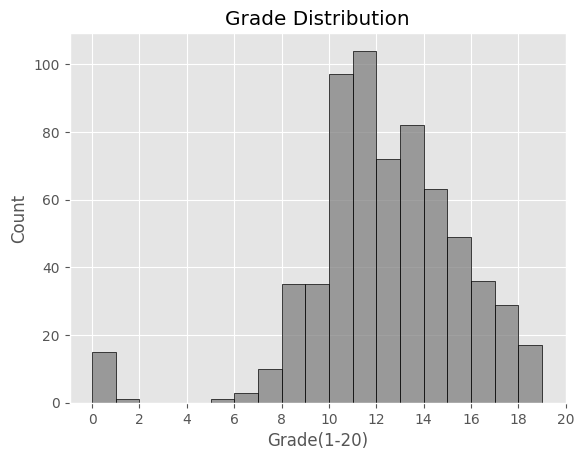

In [81]:
print(df["G3"].mean(), df["G3"].std())

h = sns.histplot(df["G3"], color='grey', edgecolor='black', binwidth=1)
h.set_xticks(range(0, 21, 2))
plt.xlabel("Grade(1-20)")
plt.title("Grade Distribution")
plt.show()

We can see here that most of the student's grades are concentrated around at the 10 - 14 section, and it is moderately spread out(3.23 std). Although the amount of 0's does skew the distribution a little bit, it is still roughly normal. This is important, as it shows that we do NOT need to fix the skewness of our distribution before applying ML algorithms.

Also, despite Linear Regression being sensititive to outliers, we will NOT remove the students which have a grade of 0 from our dataset, because the data they hold may be valuable for our analysis.

Now, we will split the data into X(features) and y(target variable) to prepare for data analysis. Because we are trying to look only for which variables influence a student's grades, we will remove all other features directly relating to grades: Specifically, G1(grades for period 1) and G2(grades for period 2) will be removed, only leaving G3(final grade) for the target variable.

In [82]:
X = df_encoded.drop(["G1", "G2", "G3"], axis=1)
y = df_encoded["G3"]

X_copy = X.copy()
y_copy = y.copy()

multi_nominal = [col for col, classes in col2class.items() if len(classes) > 2]
X = X.drop(multi_nominal, axis=1)

print(X.shape, y.shape)

(649, 26) (649,)


Linear Regression estimates, for each predictor variable, a coefficient that measures its independent effect on the target variable. More specifically, the coefficient represents the change in the target variable when increasing this variable by 1 unit while holding all other variables constant. These coefficients are often used for data analysis due to this "controlling property".

 However, when a predictor variable is highly correlated with other predictor variable(s), Linear Regression doesn't know how to measure the variable's independent effect on the target, and the coefficient will have a high standard error and a p-value that may be misleadingly low.

In order to account for this, we will take note of all variables that are highly correlated by utilizing the Variance Inflation Factor(VIF). This measures the degree of multicollinearity of a predictor variable on all other variables. A VIF > 5 for a given variable means that it is highly correlated with other variables, and we will find the variables that fit this in the dataset:

In [83]:
vifs = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
corr_features = [f for f, v in zip(X.columns, vifs) if v > 5]


print(len(corr_features))
print(len(X.columns))

15
26


That is quite a lot of correlated features - over 50% of the features have multicollinearity. However, when looking at the features themselves(e.g. Age, Daily Alchohol Consumption, Weekly Alchohol Consumption) this isn't really surprising. In order to see for each feature, specifically which features are driving up its VIF, we will look at its three most correlated features.

In [84]:
corr_matrix = X[corr_features].corr()

for corr_f in corr_features:
  corrs = dict(corr_matrix[corr_f])
  corrs = dict(sorted(corrs.items(), key = lambda x: x[1], reverse = True)[1:4])

  print(corr_f)
  print(corrs)
  print()

age
{'Dalc': 0.13476826838640513, 'goout': 0.11280462078676545, 'Walc': 0.08635734514165765}

Pstatus
{'Walc': 0.0709763877865484, 'internet': 0.05975402331960704, 'famrel': 0.05130333521913623}

Medu
{'Fedu': 0.6474766091364943, 'internet': 0.26605229807955266, 'higher': 0.2138963187215236}

Fedu
{'Medu': 0.6474766091364943, 'higher': 0.19173539497718745, 'internet': 0.18348267151922856}

traveltime
{'Dalc': 0.09282428355692025, 'goout': 0.05745419566943, 'Walc': 0.05700717799788846}

studytime
{'higher': 0.18825573167968218, 'Medu': 0.09700583290488128, 'Fedu': 0.05039964766444921}

nursery
{'Medu': 0.12595132576702953, 'Fedu': 0.07486264396343792, 'studytime': 0.042629800673668075}

higher
{'Medu': 0.2138963187215236, 'Fedu': 0.19173539497718745, 'studytime': 0.18825573167968218}

internet
{'Medu': 0.26605229807955266, 'Fedu': 0.18348267151922856, 'goout': 0.09286895547533199}

famrel
{'freetime': 0.12921567655885208, 'health': 0.10955921666418504, 'goout': 0.08970656912926568}

fre

Based off of these results, its clear that there are multiple reasons behind the high multicollinearity in the dataset. A few features are obviously directly correlated with eachother(Daily and Weekly Alcohol Consumption, along with Mother and Father's Education), and others are correlated together in a pattern. In particular, there seems to be two kinds of "clusters" of correlated features: those related to educational background/commitment, and those related to social life.

Therefore, we'll combine the alcohol consumption features together and the parents education variables together, before categorizing most of the features into the two clusters. From there, we will use a one component Principal Component Analysis to combine the correlated features in each cluster into a one-dimensional vector that can explain the variability of the features the best. The two vectors that arise from this will be the new features, and the others will be deleted. By removing the multicolinearity this way, we can trust the p-values of these two vectors when we fit the linear model.

In [85]:
X["Talc"] = X["Dalc"] + X["Walc"]
X["Edu"] = (X["Medu"] + X["Fedu"]) / 2

X = X.drop(["Dalc", "Walc", "Medu", "Fedu"], axis=1)

edu_cluster = ["studytime", "higher", "Edu"]
social_cluster = ["Talc", "goout", "freetime", "traveltime"]

edu_standard = StandardScaler().fit_transform(X[edu_cluster])
edu_pca = PCA(n_components=1).fit(edu_standard)
edu_vector = edu_pca.transform(edu_standard)
edu_vector = np.array(edu_vector).reshape(-1,)

social_standard = StandardScaler().fit_transform(X[social_cluster])
social_pca = PCA(n_components=1).fit(social_standard)
social_vector = social_pca.transform(social_standard)
social_vector = np.array(social_vector).reshape(-1,)

X["EduPC"] = edu_vector
X["SocialPC"] = social_vector

X = X.drop(edu_cluster + social_cluster, axis=1)

print(X.shape)

(649, 19)


Now we can check if any of the remaining features still have a high VIF, and we can delete those features to not bias the coefficient estimates.

In [86]:
vifs = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
corr_features = [f for f, v in zip(X.columns, vifs) if v > 5]

print(corr_features)

X = X.drop(corr_features, axis=1)

print(X.shape)

['age', 'Pstatus', 'nursery', 'famrel', 'health']
(649, 14)


Now that multicolinearity is no longer an issue, we will train the Linear Regression model and get its coefficients. We'll also get the R2 score(Percentage of variability of the target variable explained by the predictor variables) and adjust it based on the dataset's dimensionality. However, due to the lack of training-testing splits this will not be entirely accurate.

In [87]:
from sklearn.linear_model import LinearRegression

def adjusted_r2(n, p, r2):
  return 1 - (1 - r2) * ((n - 1)/(n - p - 1))

linear_model = LinearRegression().fit(X, y)

coefs = linear_model.coef_

r2 = r2_score(y, linear_model.predict(X))
print(adjusted_r2(X.shape[0], X.shape[1], r2))

0.314250383503094


Based on the whole dataset, ~31% of the variability in student's grades can be explained by the features of the dataset. During Section 2, we'll compare this to the model's performance on testing data to see if it's accurate.

There are a couple of assumptions we have to make for our regression model before  analyzing its coefficients. One of these assumptions is that the residuals are normally distributed.

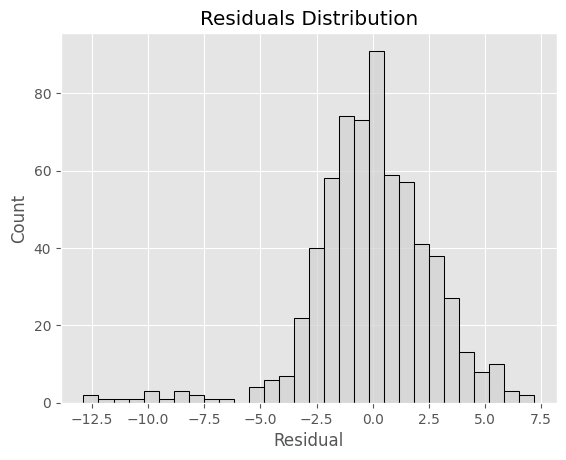

In [88]:
residuals_linear = y - linear_model.predict(X)

sns.histplot(x=residuals_linear, color='lightgrey', edgecolor='black', linewidth=0.75)
plt.xlabel("Residual")
plt.title("Residuals Distribution")
plt.show()

Based on this graph, we can see that excluding a few outliers, the residuals do follow a roughly normal distribution.

Another assumption Regression analysis makes is homoscedasticity, which essentially means that the spread of the model's residuals does not depend on the model's predicted values.

We'll plot the residual plot for our model to see if it follows this assumption:

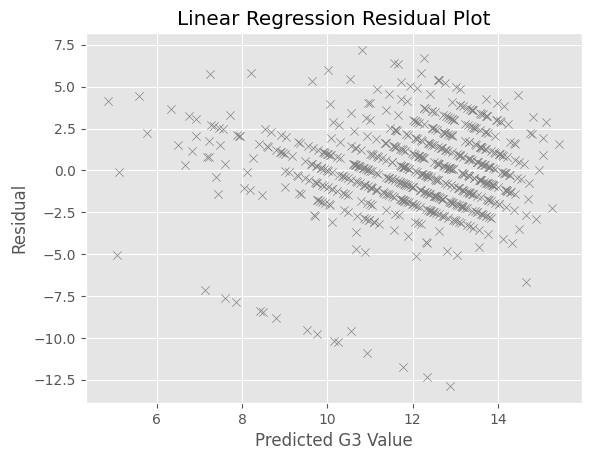

In [89]:
sns.scatterplot(x=linear_model.predict(X), y=residuals_linear, color='grey', marker='x', legend=None)
plt.xlabel("Predicted G3 Value")
plt.ylabel("Residual")
plt.title("Linear Regression Residual Plot")
plt.show()

Our residual plot shows not only outliers in residuals but also that the spread of the residuals slightly depends on the predicted G3 Value. There is a clear pattern that can be seen in the plot, indicative that the current model is heteroscedastic.

A solution is to simply change which regression model to use. In particular, we can use Robust Linear Regresison, a type of regression  that does not assume homoscedasticity. An extra bonus is that Robust Regression is also more resilient to outliers, something visibly present in our data.

Huber Regression is an example of a Robust Regression model, so we will use it instead.

In [90]:
from sklearn.linear_model import HuberRegressor

linear_model = HuberRegressor(max_iter=10000).fit(X, y)

coefs = linear_model.coef_

r2 = r2_score(y, linear_model.predict(X))
print(adjusted_r2(X.shape[0], X.shape[1], r2))

0.30471704014636936


Unsurprisingly, the R2 Score is very similar to Linear Regression's. The model also likely overfit on the data because we didn't separate it into training and testing sets.

Now that our assumptions are met, we can now analyze the coefficients of the model. However, we'll also need to see whether each coefficient is statistically significant or not, so we will find the p-values as well.

In this case, the null hypothesis for each predictor variable is that the target variable(Grades) does NOT change significantly when the predictor variable changes. Each p-value measures the probability that, given the null hypothesis is true, we would observe a coefficient as or more "extreme" as the actual coefficient.

The significance level we choose will be 0.05, meaning that there is a 5% risk whenever we reject the null hypothesis that the null hypothesis is actually true(Also known as Type I Error). In other words, if the p-value is < 0.05, we will reject the null hypothesis.

In [91]:
import statsmodels.api as sm

X2 = sm.add_constant(X)
est = sm.RLM(y, X2, M=sm.robust.norms.HuberT())
est2 = est.fit()
print(est2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                     G3   No. Observations:                  649
Model:                            RLM   Df Residuals:                      634
Method:                          IRLS   Df Model:                           14
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 30 Jul 2023                                         
Time:                        01:43:42                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9366      0.344     37.660      0.0

With these p-values in mind, we'll graph the coefficients and note the features with low p-values. We will also graph the 95% confidence intervals for each coefficient belonging to a statistically significant feature.

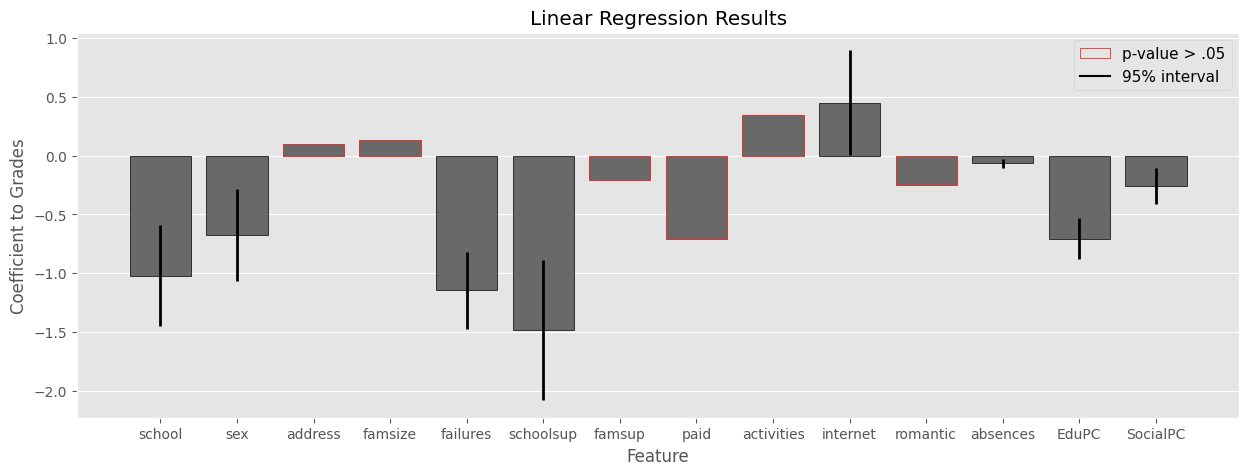

In [92]:
body = pd.read_html(est2.summary().as_html())[1].iloc[1:]
coefs = np.array(body[1].apply(lambda x: float(x)))[1:]
coef_dif = np.array((body[6].apply(lambda x: float(x)) - body[5].apply(lambda x: float(x)))/2)[1:]
p_values = np.array(body[4].apply(lambda x: float(x)))[1:]

col2coef = {X.columns[i]: coefs[i] for i in range(len(coefs))}

important_features = [X.columns[i] for i in range(len(X.columns)) if p_values[i] < 0.05]
colors = ["black" if c in important_features else "red" for c in X.columns]

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=X.columns, y=coefs, color='dimgray', edgecolor = colors)

error_bars = [coef_dif[i] if p_values[i] < 0.05 else 0 for i in range(len(X.columns))]
error_bar_width = [2.0 if p_values[i] < 0.05 else 0 for i in range(len(X.columns))]

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=error_bars, elinewidth=error_bar_width, fmt="none", c="k")

plt.legend([plt.Rectangle((0, 0), 1, 1, fc='none', ec='r'), Line2D([0], [0], color='k')],
 ["p-value > .05", "95% interval"], loc="upper right", fontsize=11)

plt.xlabel("Feature")
plt.ylabel("Coefficient to Grades")
plt.title("Linear Regression Results")
plt.show()

We can use these coefficients to get some interesting analysis of the variables:

- Both the Educational-related Principal Component and the Social-related Principal Component have a p-value < 0.05. Although we can't directly interpret their coefficients, this tells us that generally, the variables in these components(desire for higher education, alchohol consumption, etc.) do have an impact on a student's grades. These will be investigated later on.

- Being male instead of female, even when controlling for other variables such as the educational commitment principal component, results in, with 95% confidence, between a 0.288 and 1.065 deduction in predicted grades, and this is statistically significant(p-value < 0.05). We know that intelligence is irrespective of gender, so this shows how there are other features not entirely covered in this dataset that cause this.

- Oddly, getting provided educational support from a school results in a student's predicted grade decreasing by around -1.25(95% confidence interval between -0.886 and -2.08), and this is statistically significant(p-value < 0.05). Although one might argue that this is because student's recieve school support because they have done worse acedemically, this coefficient arises even after controlling for a student's past failures. However, it may be possible that student's with educational support have worse grades without neccessarily more failures, so this will be investigated more later.

- There is also not sufficient data to conclude that family educational support or getting paid classes actually impacts a student's grades(both p-values are > 0.05), even when controlling for failures and the principal component related to educational commitment. However, the reasoning for this could be similar to the one for the school support feature.

- A student's absences are, rather obviously so, very impactful to grades(p-value < 0.05). Specifically, with a 95% confidence, each 10 absences a student has reduces their predicted grade between 0.27 and 1.07. This is notable when considering that every failure a student has results in between a 0.822 and 1.47 deduction in predicted grades.

While we do know the controlled impacts of the features on the student's grades, it could also be useful to see how controlling these features impacted their coefficients. Here, we could classify features as either having a direct effect on grades(at least, based off of the features accounted for in this dataset), an indirect effect on grades, or no effect on grades.

In order to do this, we will plot a graph in which we compare, for each feature, the coefficient of a Single Linear Regression between the feature and grades with the overall "controlling" coefficient:


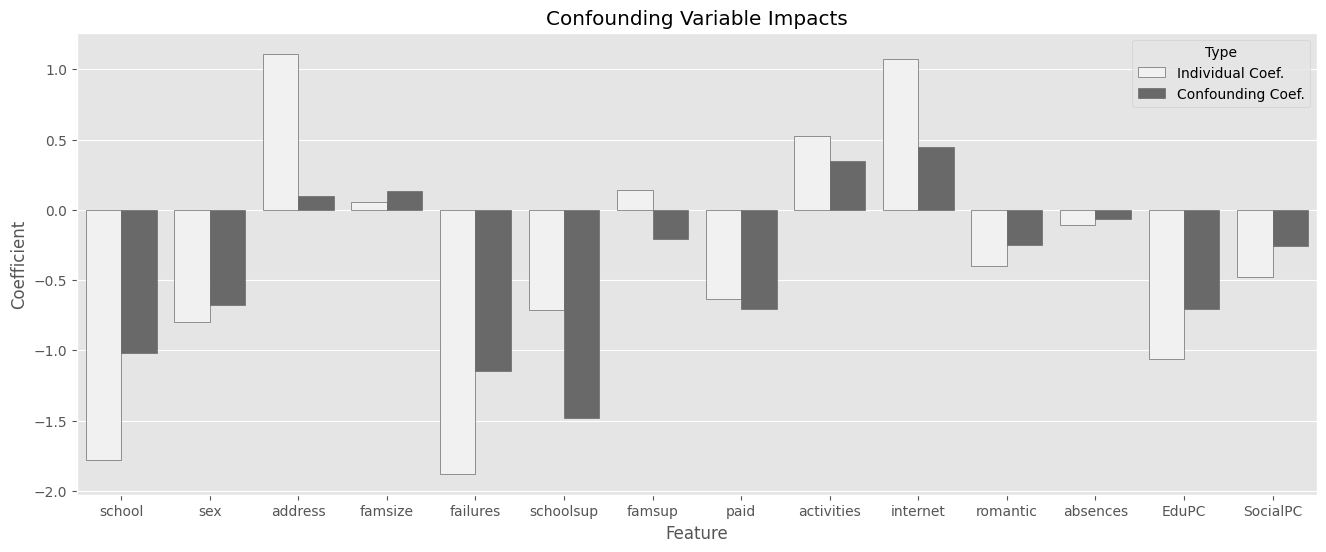

In [93]:
def dif_mean(col):
  single_reg = HuberRegressor().fit(np.array(X[col]).reshape(-1,1), y)
  coef = single_reg.coef_[0]
  return coef

difs = [dif_mean(col) for col in X.columns]
binary_coefs = [col2coef[col] for col in X.columns]

temp_df = pd.DataFrame({
    "Feature":X.columns,
    "Individual Coef.":difs,
    "Confounding Coef.":binary_coefs
})
temp_df = pd.melt(temp_df, id_vars="Feature")
temp_df = temp_df.rename(columns={"variable": "Type"})

plt.figure(figsize=(16,6))
sns.barplot(x="Feature", y="value", hue="Type", data=temp_df, color="dimgrey", edgecolor = "dimgray")
plt.ylabel("Coefficient")
plt.title("Confounding Variable Impacts")

plt.show()

Based off of this graph, we can see which features actually have an effect on a student's grades and which features have an indirect effect. However, in order to truly analyze it, we need to see which features specifically are causing the confounding coefficient to change for every feature.

For every feature, we will compare the Single Linear model coefficient with the same coefficient after including a second variable. This nested for loop will run for every single feature, and whenever adding another variable has a >= 20% influence on the coefficient, it will be noted as a confounding variable.

In [94]:
def percent_dif(mean0, mean1):
  p = (100*mean1 - 100*mean0) / mean0
  return p

def confounding_variable_impact(col, confound_col):
  reg_mean = dif_mean(col)
  multi_reg = HuberRegressor().fit(X[[col, confound_col]], y)
  coef_col = multi_reg.coef_[0]

  return percent_dif(reg_mean, coef_col)

col2confounding = {col: {} for col in X.columns}

for col in X.columns:
  for feature in X.columns:
    if feature != col:
      impact = confounding_variable_impact(col, feature)
      if abs(impact) >= 20:
        col2confounding[col][feature] = impact

for col, the_dict in col2confounding.items():
  if len(list(the_dict.keys())) > 0:
    print(col)
    print(the_dict)
    print()

school
{'EduPC': -43.27223649266554}

sex
{'failures': -23.710843042969135, 'SocialPC': -33.10637673431612}

address
{'school': -54.2911314242081, 'EduPC': -49.59195248507974}

famsize
{'school': 33.201570217592206, 'sex': 226.66618303858525, 'address': -238.171718204843, 'failures': -124.73114499098016, 'schoolsup': -35.456462894252894, 'paid': -34.809774027152955, 'internet': -46.07019312899599, 'absences': 84.92456171931912, 'EduPC': 75.83863943295667, 'SocialPC': 108.86161895595528}

failures
{'EduPC': -26.921422512826503}

schoolsup
{'school': 54.4990226847739, 'sex': 28.09153242874809, 'EduPC': 59.95483778688439, 'SocialPC': 37.43479588595726}

famsup
{'school': -64.01233656642441, 'sex': -52.38877478692656, 'address': 25.398984174180438, 'schoolsup': 29.3876336829654, 'paid': 31.142237430678865, 'internet': -78.67458467259013, 'EduPC': -337.8449935910666, 'SocialPC': -33.06690646539201}

paid
{'sex': -23.451672080014575, 'failures': -56.419158012164154, 'internet': 24.5454286599

Based off of these results and the preceding graph, we can make the following observations:

- A student's extracirricular activities matters less when controlling for the educational commitment prinicipal component, potentially explaining why it's p-value was > 0.05. This means that without the educational commitment to learn and grow from extracirriculars, they don't neccessarily have an effect on grades.

- Interestingly, the school educational support coefficient became more negative after accounting for other variables, notably educational commitment and the school itself.

- Despite common belief, when accounting for educational commitment, romantic relationships do not neccessarily have a negative impact on grades. In other words, if a student has a good educational background, having a relationship won't have a negative impact on their grades.

In order to check whether school educational support inherently leads to a decrease in student's grades, or if it's simply because students who get educational support have worse grades to begin with, we'll model the relationship between first and final period grades for students with and without school support.



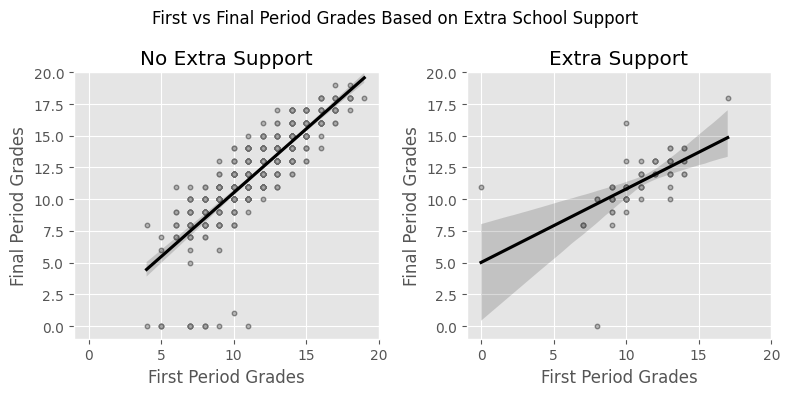

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

sns.regplot(ax=ax[0], x="G1", y="G3", data=df[df["schoolsup"] == "no"],
            scatter_kws={"color": "darkgrey", "edgecolor":"dimgrey", "s":10}, color="black")
sns.regplot(ax=ax[1], x="G1", y="G3", data=df[df["schoolsup"] == "yes"],
            scatter_kws={"color": "darkgrey", "edgecolor":"dimgrey", "s":10}, color="black")

ax[0].set_title("No Extra Support")
ax[1].set_title("Extra Support")
plt.suptitle("First vs Final Period Grades Based on Extra School Support")

ax[0].set_xlabel("First Period Grades")
ax[0].set_ylabel("Final Period Grades")
ax[1].set_xlabel("First Period Grades")
ax[1].set_ylabel("Final Period Grades")

ax[0].set_xlim([-1, 20])
ax[1].set_xlim([-1, 20])
ax[0].set_ylim([-1, 20])
ax[1].set_ylim([-1, 20])
fig.tight_layout()
plt.show()

If there truly was an inherit negative grade outcome just from getting school educational support, we'd notice that the regression line for the students with school support would have a much lower slope than students without, as the support system would "push" the students away from their shown potential(that being the first period grades). However, when accounting for the confidence interval in the second regression line, we cannot prove that there is a difference between the two lines. Therefore, the coefficient of schoolsup in the Robust Linear Model is likely due to students getting school support having lower grades to begin with.



Another interesting observation was how the sex feature's coefficient became less important when accounting for the prinicipal component related to social activities(alcohol consumption, free time, etc.). In order to examine the reason for this change more closely, we'll plot how each gender's grades respond to a high weekend alchohol consumption.

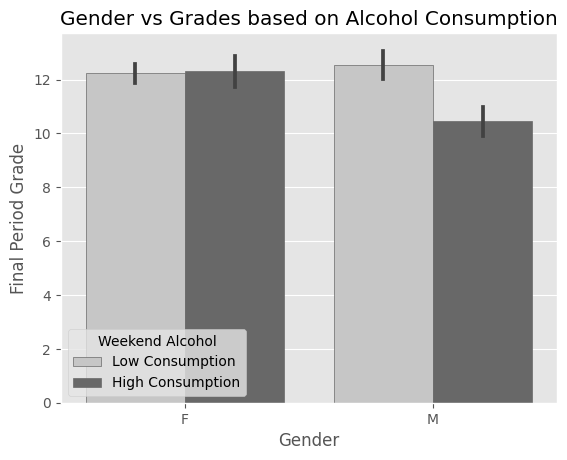

In [96]:
df["Weekend Alcohol"] = df["Walc"].apply(lambda x: "High Consumption" if x > 2 else "Low Consumption")
sns.barplot(x="sex", y="G3", hue="Weekend Alcohol", data=df, edgecolor="dimgrey", palette="Greys")

plt.xlabel("Gender")
plt.ylabel("Final Period Grade")
plt.title("Gender vs Grades based on Alcohol Consumption")
plt.show()

df = df.drop("Weekend Alcohol", axis=1)

Notably, male students with high weekend alcohol consumption tended to have lower grades than female students with the same trait. This could be due to a multitude of reasons; perhaps these male students tend to have a worse relationship with alcohol compared to their female counterparts, or male students with bad grades resort to alcohol as a coping mechanism at a higher rate. Whatever the cause is, it is beyond the scope of what this dataset can offer.

Other than Regression analysis, another method for data analysis is looking at a Decision Tree chart. Decision Trees are a type of ML algorithm which use decisions based off of features to predict data. In short, they run through a list of potential splits they can make off of the data, and whichever split results in the highest purity(the resultant groups are the most different from one another) will be the accepted one. The split will be made, and the process will continue. As a result, at the end of this process, the most purifying(important) splits will be at the top of the decision tree, and they will get more specific and less important as the tree increases in depth. Also, due to the nature of these comparisons, Decision Trees require little data preparation - there is no need for scaling, ensuring no multicollinearity, etc.

A powerful aspect of Decision Trees are that they can capture non-linear relationships between data, unlike linear regression. By taking a look at Decision Trees, deeper inferences can be made about the data. In this case, we'll look at a Decision Tree with a depth of 4 which attempts to predict a student's grades off of all of the features. We'll also make the minimum of samples per leaf(a leaf being a final prediction) 10 so that the Decision Tree doesn't overfit off of very limited data.

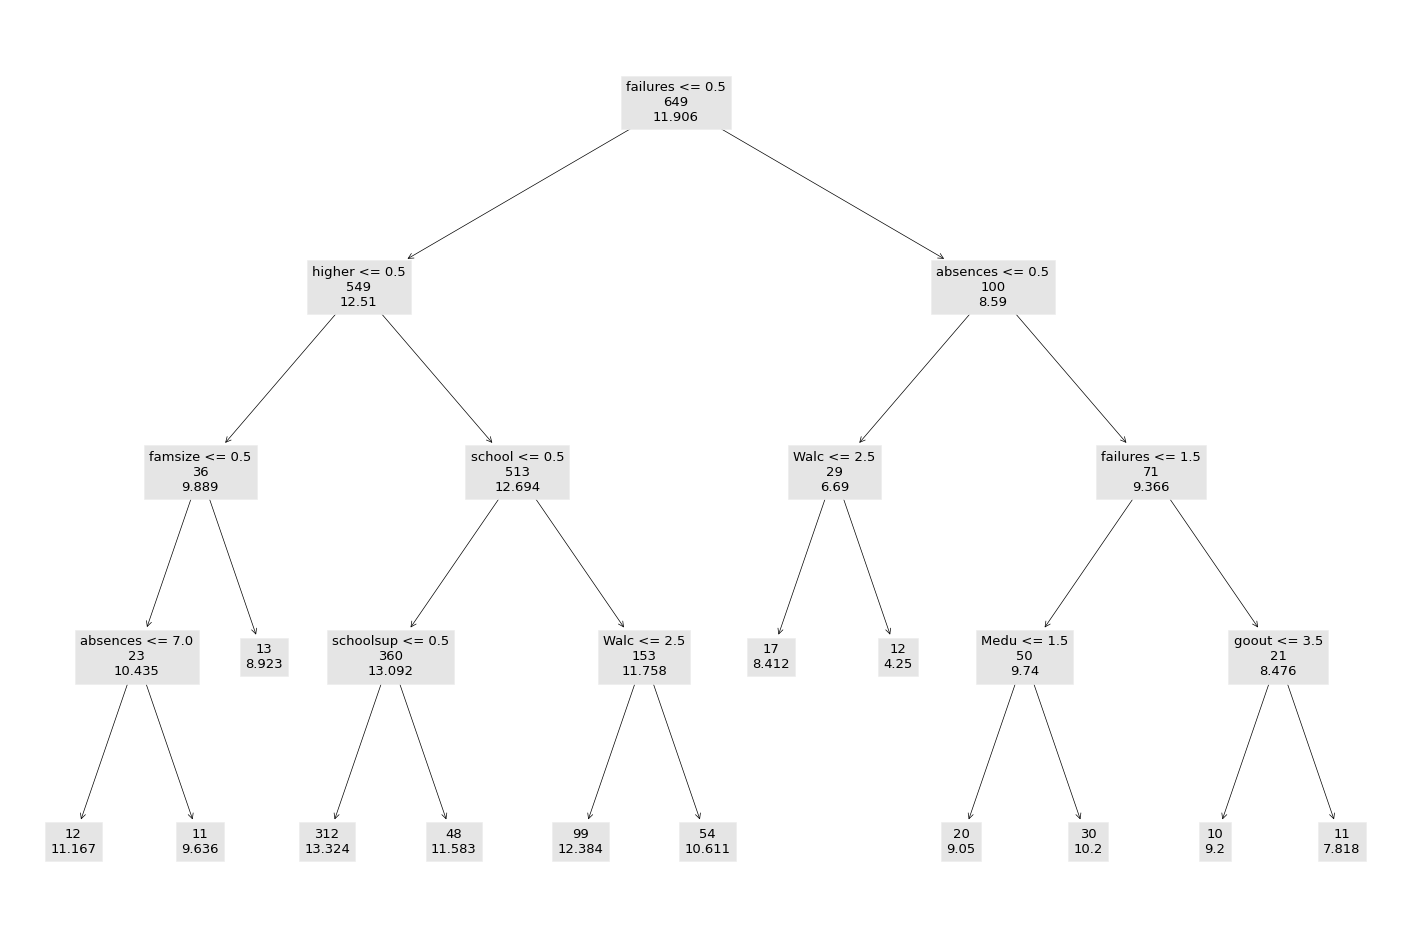

In [97]:
dt_4 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=10).fit(X_copy, y_copy)
plt.figure(figsize=(18,12))
_ = plot_tree(dt_4, feature_names=X_copy.columns, label=None, impurity=False)

One variable to no surprise stands out from this tree: failures, clearly the most important variable when predicting a student's grades. Howevever, a couple of other interesting phenomenons can be observed.

As an example, for student's who did not desire higher education, the tree looked at absences(which likely indicated whether those students still cared about the school), but also interestingly looked at family size - a feature deemed uncorrelated to grades by the linear model. This suggests that there may be a non-linear correlation between family size and grades, something that will be checked later on.

Another interesting observation is that having absences wasn't always deemed to lead to worse grades by the tree. For students with failures, having at least one absence actually led to on average a higher predicted grade. Perhaps the relationship between absences and grades isn't as linear as many believe - this will also be investigated later on in the notebook.

# Section 2: Machine Learning

We will now use multiple Machine Learning algorithms to test how well a model can predict a student's grades given the demographics and past information about the student, as well as get some other information on the features that the linear model couldn't get.

To start off, we will split our data into training and testing datasets. Although the models will be evaluated through cross validation on the training set, the testing set is essential to make sure under new data the models still work well.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size=0.20, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(519, 30) (519,)
(130, 30) (130,)


For this section, we will test four ML algorithms other than Linear Regression:

1. Support Vector Regression: Instead of Linear Regression, which attempts to fit a line on the data to minimize the residuals, an SVR attempts to fit a hyperplane on the data that can both fit the data points well and can maximize a distance known as the margin. The margin is the distance between the hyperplane and its closest data points(known as support vectors, as they essentially define what the hyperplane ends up being). A key feature of Support Vector Machines is kernels: these can be used to find a hyperplane in a higher dimension and "broadcast" it back to the lower dimension, allowing SVMs the ability to capture non-linear relationships. Due to SVM's kernel trick and their general superior performance on limited data(such as this dataset), we will test an SVR.

2. Random Forest Regression: This is a modification of the Decision Tree algorithm that instead trains a significant amount of small Decision Trees(known as weak learners) on random subsets of data. From there, given new data to predict off of, the Random Forest will take the mean of all of the weak learners' predictions and predict that. Random Forests generally perform well, and as such we will test them.

3. Gradient Boosting Regression: This is similar to Random Forests, except the weak learners are trained one at a time: the first weak learner is trained off of the data, and then based on what the learner got wrong, the data is modified before sending it off to the second weak learner to ensure that the second weak learner gets those wrongfully predicted data points correct. These also perform well, which is why we will test them, although it is important to note they are more prone to overfitting.

4. XGBoosting Regression: XGBoost is very similar to Gradient Boosting, except it focuses more on regularization(combatting overfitting). Due to it solving a pretty big issue Gradient Boosting has, it performs well, and we will use it.

There are two practices we're going to perform on the dataset: K-fold cross validation and grid searching.

K-folds is a method of estimating the accuracy of a dataset which splits the given dataset into k splits, and for each split, trains the given model on the rest of the splits and obtains the accuracy for that split. After each split's respective accuracy is obtained, K-folds returns the average. K-folds is superior to the regular training-testing method for getting a model's accuracy as it prevents selection bias.

Grid Searching is the process of using given data to find the best-performing parameters for a model, given a set of parameters to test. GridSearchCV in particular does this by using K-fold cross validation to test the accuracy of every parameter given, and returning the parameter which performs the best.

We will use Grid searching on all 4 of these models to try and get their highest performing version. For the SVR, we will optimize the C parameter, which dictates how "hard" the hyperplane will attempt to fit on the training set. The larger the C value, the smaller the margin will be, making the SVR fit better on the training set but more prone to overfitting. For the other tree-best models, we will just optimize how many weak learners will be present.

In [99]:
def best_params(alg, params, scale=False):
  search = GridSearchCV(
      alg,
      params,
      cv=10,
      scoring="neg_root_mean_squared_error",
      verbose=1
  )

  if scale:
    search.fit(StandardScaler().fit_transform(X_train), y_train)
  else:
    search.fit(X_train, y_train)
  return search.best_params_, search.best_score_

print(best_params(SVR(), {'C': [0.001, 0.01, 0.1, 1, 10]}, True))
print(best_params(RandomForestRegressor(), {'n_estimators':[50, 100, 500]}))
print(best_params(GradientBoostingRegressor(), {'n_estimators':[50, 100, 500]}))
print(best_params(XGBRegressor(), {'n_estimators':[50, 100, 500]}))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
({'C': 1}, -2.768691874729957)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
({'n_estimators': 100}, -2.793325171947199)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
({'n_estimators': 50}, -2.849452545343211)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
({'n_estimators': 100}, -3.0245737410093305)


Given these parameters, we will use each of these models and compare their performances with Linear Regression to see if there is any difference in accuracy.

Although we can see the RMSE for each best-performing model, it would also be useful to get its standard deviation as well as the list of the cv results. Rather than just using a 10-fold cross validation method, we will also sample each cv 10 times so we can obtain 100 samples for each model, making the analysis on each model's performance more accurate.

In [100]:
sv_model = SVR(C=1)
rf_model = RandomForestRegressor(n_estimators=500)
gb_model = GradientBoostingRegressor(n_estimators=50)
xg_model = XGBRegressor(n_estimators=100)

def mean_std_cv(model, times, X_train, y_train, scoring="neg_root_mean_squared_error"):
  all_scores = []

  for i in range(times):
    scores = np.abs(cross_val_score(model, X_train, y_train, cv=10, scoring=scoring))
    all_scores += list(scores)

  all_scores = np.array(all_scores)
  print(all_scores.mean(), all_scores.std())
  return all_scores, all_scores.mean(), all_scores.std()

cv_lr, m_lr, s_lr = mean_std_cv(LinearRegression(), 10, StandardScaler().fit_transform(X_train), y_train)
cv_sv, m_sv, s_sv = mean_std_cv(sv_model, 10, StandardScaler().fit_transform(X_train), y_train)
cv_rf, m_rf, s_rf = mean_std_cv(rf_model, 10, X_train, y_train)
cv_gb, m_gb, s_gb = mean_std_cv(gb_model, 10, X_train, y_train)
cv_xg, m_xg, s_xg = mean_std_cv(xg_model, 10, X_train, y_train)

2.835527527519279 0.5218322226810108
2.768691874729957 0.5387471537240225
2.79752555591582 0.5094946579124461
2.8519930461051684 0.49842306689801386
3.0245737410093305 0.5248352998599399


First of all, we can see that the RMSE values for all the other ML models have little differences to the Linear Regression one. We can also see that the standard deviations for each model are quite large: ~0.50 for a mean of just ~2.8. This is likely due to the small dataset given and the general lack of accuracy the models have, making the performance on the training-testing split for each sample highly dependent on the specific split.

A common way of seeing how the model would perform on unseen data is to use confidence intervals: given a % confidence, one can assess the range of accuraries that the model would have on unseen data. For each model, we will use a 95% confidence.

In [101]:
def confidence(level, samples, mean, std):
  z_score = stats.norm.ppf((1 + level) / 2)
  moe = z_score * (std/np.sqrt(samples))
  return str(mean - moe) + " - " + str(mean + moe)

print("Linear Regression: " + confidence(0.95, 100, m_lr, s_lr))
print("SVM: " + confidence(0.95, 100, m_sv, s_sv))
print("Random Forest: " + confidence(0.95, 100, m_rf, s_rf))
print("Gradient Boosting: " + confidence(0.95, 100, m_gb, s_gb))
print("XGBoost: " + confidence(0.95, 100, m_xg, s_xg))

Linear Regression: 2.733250291276552 - 2.9378047637620055
SVM: 2.663099372922702 - 2.874284376537212
Random Forest: 2.697666437933425 - 2.8973846738982147
Gradient Boosting: 2.754303920086758 - 2.9496821721235786
XGBoost: 2.9217079124552545 - 3.1274395695634065


We can see that although each model generally has similar ranges, there are slight differences, especially for the XGBoost.

In order to know whether the differences between the model's ranges occured purely by chance or are actually meaningful, we can use a t-test. A t-test verifies, given two distributions, whether the difference between the means of the distributions is statistically significant or not. In particular, the t-test returns the p-value(where the null hypothesis is that the differences between the means are virtually the same), which we will utilize here with a 95% confidence.

The type of t-test we'll use is a 5x2 paired t-test. For each model, this t-test gets its accuracy distribution by running 5 runs of 2-fold cross validation(each split on the dataset random). This is generally recommended over just a 10-fold t-test as the 10-fold test has high Type I error.

In this case, we will use the 5x2 t-test to compare Linear Regression with each of the other algorithms, to see if there truly is an advantage to use a more non-linear approach. We will hold a 95% confidence, only rejecting the null hypothesis if the p-value < 0.05.

In [102]:
def get_p_value(model1, model2, scale=False):
  train_data = X_train.copy()
  if scale: train_data = StandardScaler().fit_transform(train_data)

  t, p = paired_ttest_5x2cv(estimator1=model1,
                            estimator2=model2,
                            X=train_data,
                            y=y_train,
                            scoring='neg_root_mean_squared_error',
                            random_seed=0)
  return p

print(get_p_value(LinearRegression(), rf_model))
print(get_p_value(LinearRegression(), gb_model))
print(get_p_value(LinearRegression(), sv_model, True))
print(get_p_value(LinearRegression(), xg_model))

0.8337809020317142
0.549342394146112
0.2870835885835139
0.057759894629408


Based off of these results, we can conclude with a 95% confidence that each of the models have no difference in RMSE values with each other. This shows that no matter the "flexibility" of our model choice, our predictions won't be anymore accurate; the data given isn't "good" enough at explaining the G3 feature to the point where optimizing a model will improve its accuracy.

We can also make a box plot for each of the cross validation results to visually see any noteable differences:

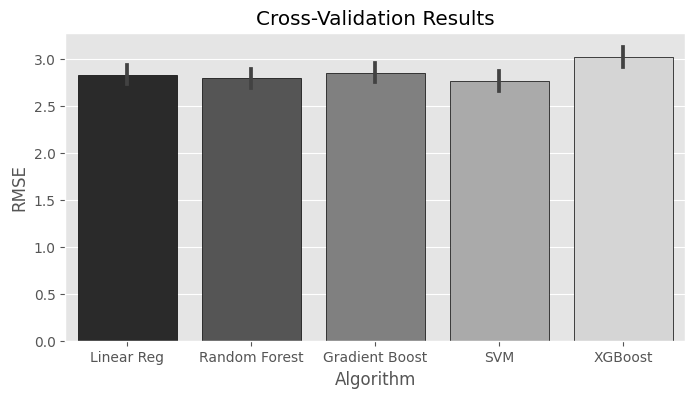

In [103]:
all_scores = list(cv_lr) + list(cv_rf) + list(cv_gb) + list(cv_sv) + list(cv_xg)
algos = ["Linear Reg" for i in range(10*10)] + ["Random Forest" for i in range(10*10)] + ["Gradient Boost" for i in range(10*10)] + ["SVM" for i in range(10*10)] + ["XGBoost" for i in range(10*10)]

plt.figure(figsize=(8,4))
sns.barplot(x=algos, y=all_scores, palette="gray", edgecolor="black")
plt.xlabel("Algorithm")
plt.ylabel("RMSE")
plt.title("Cross-Validation Results")
plt.show()

We can see here that, when accounting for the error bars, each algorithm is very similar in its cross validated RMSE.

Support Vector Machines are powerful with limited amounts of data, but also suffer from a phenomenon known as the curse of dimensionality. This is a phenomenon in many ML algorithms where in the prescence in data with a high amount of dimensions relative to the sample size, there is a lot of "noise" in the data, and the model will fit inaccurately on this "noise" and get subpar results.

This dataset has a lot of dimensions(features) relative to its size, and as such the SVR may be performing lower than its potential. In order to check to see whether this is true or not, we will test it on the original 14-dimensional X data with the principal components that we used for Regression analysis earlier.

In [110]:
cv_sv, m_svm, s_svm = mean_std_cv(SVR(), 10, StandardScaler().fit_transform(X), y)

2.6865632094013905 0.8211535706344838


Although the SVM does appear to do slightly better, comparing the resultant RMSE with the confidence interval obtained by the previous SVM shows that it is still within the 95% confidence range. In other words, we can't neccessarily conclude this actually improved the SVM's accuracy by any significant amount.

Although we've mainly been evaluating the models using cross validation on the training dataset, we will also check and ensure that the models perform equally well on the untouched testing dataset.

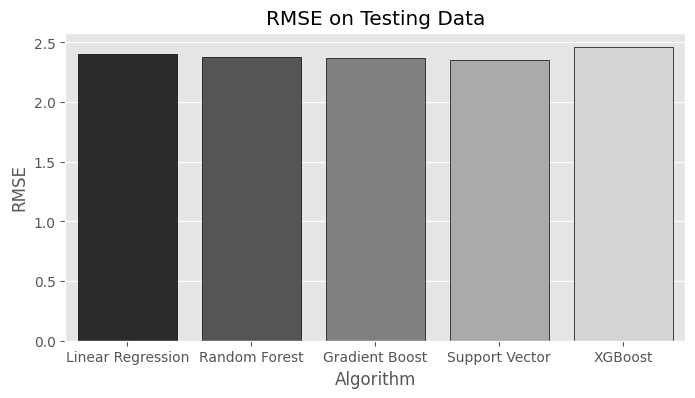

In [105]:
scaler = StandardScaler().fit(X_train)

lr_model = LinearRegression().fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
sv_model.fit(scaler.transform(X_train), y_train)
xg_model.fit(X_train, y_train)

rmse_lr = np.sqrt(mean_squared_error(y_test, lr_model.predict(X_test)))
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test)))
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_model.predict(X_test)))
rmse_sv = np.sqrt(mean_squared_error(y_test, sv_model.predict(scaler.transform(X_test))))
rmse_xg = np.sqrt(mean_squared_error(y_test, xg_model.predict(X_test)))

plt.figure(figsize=(8,4))
sns.barplot(x=["Linear Regression", "Random Forest", "Gradient Boost", "Support Vector", "XGBoost"],
            y=[rmse_lr, rmse_rf, rmse_gb, rmse_sv, rmse_xg], palette="gray", edgecolor="black")
plt.xlabel("Algorithm")
plt.ylabel("RMSE")
plt.title("RMSE on Testing Data")
plt.show()

Based on these results, the models perform similarly well on the testing data than on cross validation on the training dataset. We will now check the range for the (adjusted) R2 score for Linear Regression:

In [125]:
cv_lr_r2, m_lr, s_lr = mean_std_cv(LinearRegression(), 10, StandardScaler().fit_transform(X_copy), y_copy, "r2")
c = confidence(0.95, 100, m_lr, s_lr)

left_adj = adjusted_r2(X.shape[0], X.shape[1], float(c.split(" - ")[0]))
right_adj = adjusted_r2(X.shape[0], X.shape[1], float(c.split(" - ")[1]))
print(f"Adjusted R2 Range: {left_adj} - {right_adj}")

0.17336494017929674 0.1194133906502953
Adjusted R2 Range: 0.13118975394898758 - 0.17903258433550528


We can conclude based off of this that the given predictor features can explain between 13-18% of the variability of a student's grades, further reinforcing that there are important features not covered in the dataset.

Finally, we can use the feature importances from the tree-based algorithms and compare them with the Linear Regression feature importances. For the tree-based algorithms, the features that are higher up in the tree are seen as more important, and this can be mathematically measured through Gini Importance. For Linear Regression, after transforming each variable to a Standard Normal Distribution(mean of 0 and standard deviation of 1) and getting each coefficient, the higher coefficients are inherently more important as each feature is standardized.

In order to create a graph that directly compares each feature importance, even if for Linear Regression the scale of feature importances is way different than in Random Forests or Gradient Boosting, we will instead measure each feature importance as its "rank" in importance relative to the other feature importances in the model. For example, if the importances for a model were [0.13, 0.15, 0.11, 0.22], it would be transformed to [3, 4, 1, 2], with the higher "rank" being more important.

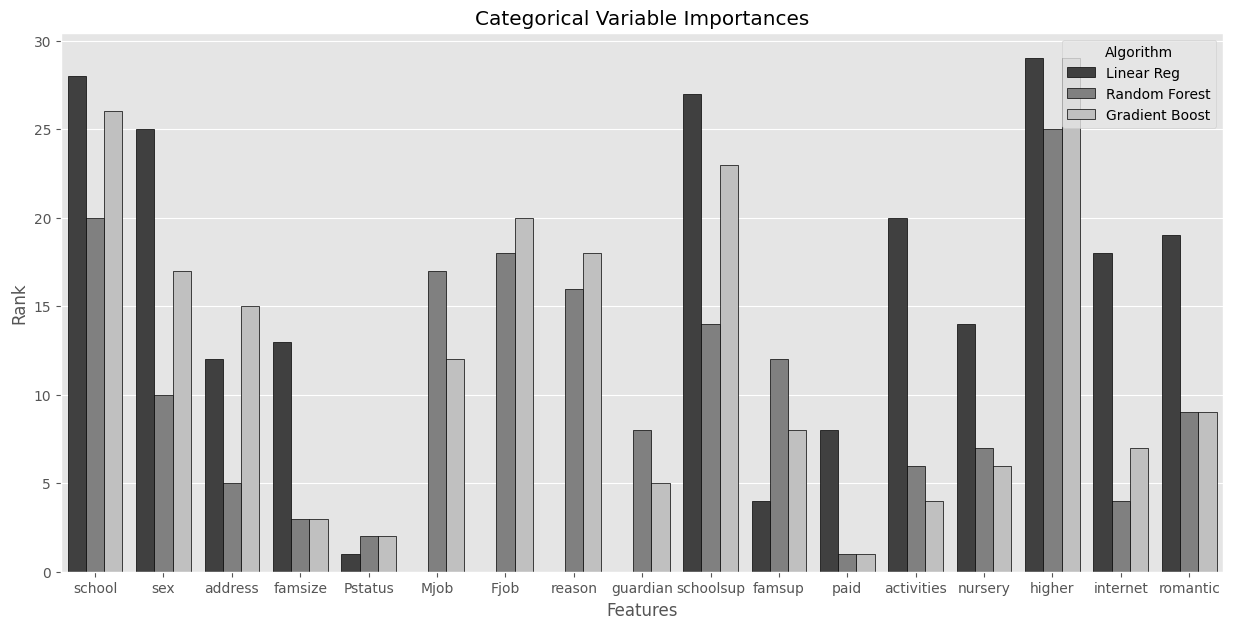

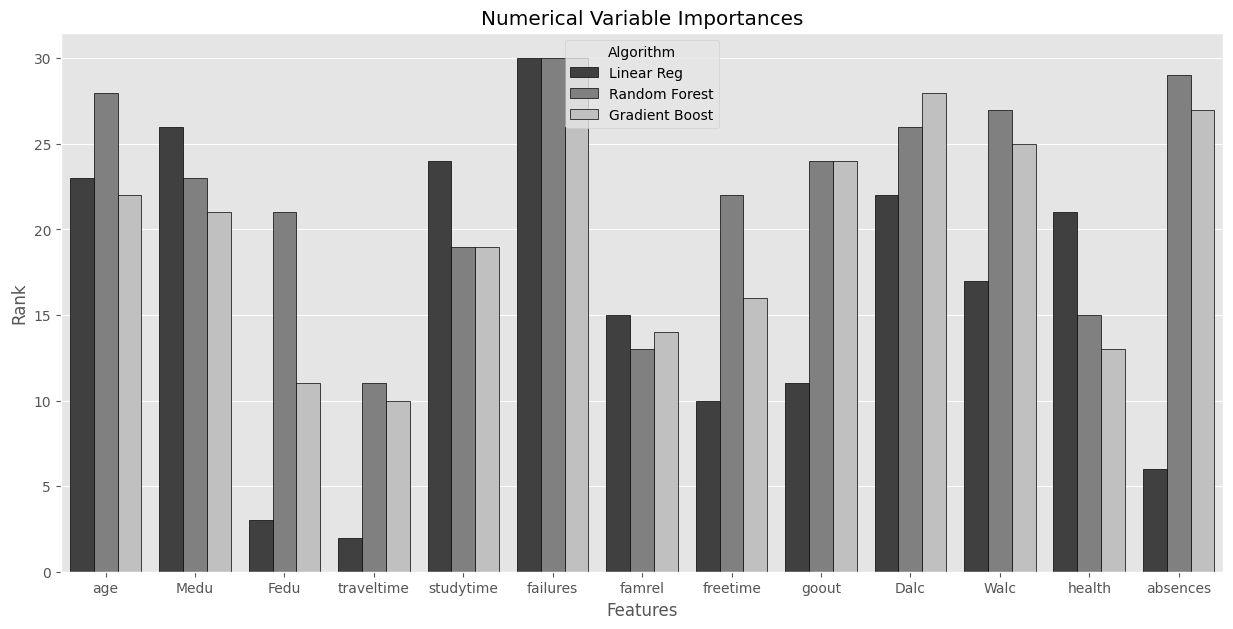

In [126]:
def arr_to_rank(arr):
  return arr.argsort().argsort() + 1

standard_linear = LinearRegression().fit(StandardScaler().fit_transform(X_train), y_train)

features = list(X_train.columns)
standard_coef = arr_to_rank(np.abs(standard_linear.coef_))
rf_coef = arr_to_rank(rf_model.feature_importances_)
gb_coef = arr_to_rank(gb_model.feature_importances_)

def plot_col_coefs(cols, title):

  all_coefs = list(standard_coef) + list(rf_coef) + list(gb_coef)
  all_features = features * 3
  algos = ["Linear Reg" for i in range(len(features))] + ["Random Forest" for i in range(len(features))] + ["Gradient Boost" for i in range(len(features))]

  counter = 0
  for i in range(len(all_features)):
    if all_features[counter] in multi_nominal and algos[counter] == "Linear Reg":
      all_coefs[counter] = 0
    if all_features[counter] not in cols:
      all_coefs.pop(counter)
      all_features.pop(counter)
      algos.pop(counter)
      counter -= 1
    counter += 1

  temp_df = pd.DataFrame({
      "Features":all_features,
      "Rank":all_coefs,
      "Algorithm":algos
  })

  plt.figure(figsize=(15,7))
  sns.barplot(x="Features", y="Rank", hue="Algorithm", data=temp_df, palette="gray", edgecolor="black")
  plt.title(title)
  plt.show()

categorical = [col for col in X_copy.columns if df.dtypes[col] == object]
numerical = [col for col in X_copy.columns if df.dtypes[col] != object]
plot_col_coefs(categorical, "Categorical Variable Importances")
plot_col_coefs(numerical, "Numerical Variable Importances")

When comparing the feature importances for each feature, we can infer possible non-linear relationships in the data along with the impact of confounding variables. We can also take into note how Linear Regression controls for other variables and looks for a linear relationship, while tree-based models do not control for variables and can incorporate non-linear relationships. Some of the variables show interesting patterns:

- The family size feature was placed as very little importance by the tree-based models. This is despite the Decision Tree in the Data Analysis section which seemed to show that there might've been a non-linear relationship between family size and grades. This means that the Decision Tree in that branch was simply dealing with a low amount of data and was partioning the data rather randomly.

- Features such as engaging in extracirricular activites, having family educational support, not having a romantic relationship, etc.. are likewise ranked as low importance for grades by both the regression and tree-based models. This reaffirms the idea that factors such as these that are traditionally associated with better grades may not have as much of an impact as one may think.

- Features like going out, alchohol consumption, and absences are placed as more important in the tree-based models than the Linear-based ones. This could mean two things: either these variables aren't that important when accounting for confounding variables, or there is an important, non-linear relationship between these variables and grades. Looking at the confounding impact graph for Linear Regression(which generally shows a moderate confounding impact for these features), it is likely a mixture of both of these.

- Features like studying time, desire for higher education, and family educational background are highly valued in all of the models, affirming that these are one of the most important factors behind a student's grades.

### Part 3: Final Conclusion

One of the top priorities of every school is to ensure the acedemic success of their students, which is reflected through their students' grades. Thus, it is vital to understand the factors behind student's grades in order to make policies that will best improve them. This is the motive behind this analysis: to understand which factors affect student's grades, and the next path for schools to take based off of said factors.

A common way schools will attempt to increase their students' acedemic ability is through establishing educational and extracirricular support programs. However, based off of this analysis, these may have tangible effects on student's grades. Schools should instead invest their focus in other methods of improving their student's grades instead.

The main finding of this analysis is that the only aspects of a student that truly affect their grades is their educational dedication, shown through their desire for higher education and studying time. All other aspects of a student - such as engaging in extracirricular activities - only improve their grades if they have the acedemic drive to utilize their opportunities. Therefore, schools should put more effort in increasing their student's educational dedication, possibly by establishing a positive learning culture, providing acedemic leadership oppurtunities, and celebrating/rewarding the acedemic achievements of their students.

Despite all of this, there is still a significant gap in knowledge in what truly affects a student's grades. Even when applying several advanced machine learning models, the given data(which included a student's age, studying time, desire for higher education, and much more) could only explain 13-18% of the variability in grades. More data collection and studies must be conducted to get a deeper understanding for students' acedemic success. Perhaps a good start would be observing how social phenomenons affect grades - as an example noted in this analysis, how alcohol consumption affects the grades of male vs female students differently, and why.